# Identification
Please indicate your name

Student 1: Yalda Eftekhari

Student 2: Defne Gulmez

# Practical work 8: Color quantification and search by content


In this practical work session, we will:

- Develop a color based descriptor that can be applied to every image in a database
- Use this color descriptor to create a method that searches images by content: the goal is to find the images that are the most similar to a query.

In [32]:
# Load useful library

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import scipy.ndimage
from skimage.color import rgb2hsv, hsv2rgb

# Usefull functions
def setColors(nH, nS, nV):
    """ int**3 -> Array[nH*nS*nV,3]*Array[nH,nS,nV,3]
        computes an RGB palette from a sampling of HSV values
    """
    pal1 = np.zeros((nH*nS*nV, 3))
    pal2 = np.zeros((nH, nS, nV, 3))
    tH, tS, tV = 1/(2*nH), 1/(2*nS), 1/(2*nV)

    idx = 0
    for i in range(nH):
        for j in range(nS):
            for k in range(nV):
                HSVval = np.array([[[i/nH + tH, j/nS + tS, k/nV + tV]]])
                pal1[idx, :] = hsv2rgb(HSVval)*255  
                pal2[i, j, k, :] = hsv2rgb(HSVval)*255
                idx += 1
    return pal1, pal2

def viewQuantizedImage(I,pal):
    """ Array*Array -> Array
        Display an indexed image with colors according to pal 
    """
    Iview = np.empty(I.shape)
    n, m, c = I.shape
    for i in range(n):
        for j in range(m):
            h, s, v = I[i, j, :]
            Iview[i, j, :] = pal[ np.int_(h), np.int_(s), np.int_(v), :]
    print( Iview.max())
    plt.imshow(Iview/255)
    plt.show()

def display5mainColors(histo, pal):
    """ Array*Array -> NoneType
        Display the 5 main colors in histo 
    """
    idx = np.argsort(histo)
    idx = idx[::-1]
    K = 5
    for i in range (K):
        Ia = np.zeros((1, 1, 3), dtype=np.uint8)
        Ia[0,0,0] = pal[idx[i], 0]
        Ia[0,0,1] = pal[idx[i], 1]
        Ia[0,0,2] = pal[idx[i], 2]
        plt.subplot(1, K, i+1)
        plt.imshow(Ia)
        plt.axis('off')
    plt.show()

def display20bestMatches(S, indexQuery):
    """ Array*int -> NoneType 
    """
    L = S[indexQuery, :]
    Idx = np.argsort(L)[::-1]
    cpt = 1
    plt.figure(figsize=(15, 10))
    for idx in Idx[:20]:
        plt.subplot(5, 4, cpt)
        indexQuery = idx
        imageName = (pathImage+listImage[indexQuery]).strip()
        plt.imshow(np.array(Image.open(imageName))/255.)
        plt.title(listImage[indexQuery])
        plt.axis('off')
        cpt += 1
    plt.show()

## Exercise 1: HSV histogram computation

Each image of the base will be represented by its color histogram in the HSV representation. We use the HSV representation rather than the RGB representation because it is a perceptual color space: two colors that look similar will have close HSV vectors.

1) Write a function ```iv = quantize(v,K)``` that returns the quantized interval of `v` considering a uniform quantization of values over the range $[0,1]$ with `K` evenly spaced intervals. For an image value v=1, the function will return K-1.

In [33]:
def quantize(I, k):
    """ float*int -> int 
    """
    if I == 1:
        return int(k-1)
    return int(I*k)


# You can test your function with the following lines:
h = np.zeros((8))
for i in range(256):
    h[quantize(i/255.,8)] += 1
assert (h == 32*np.ones((8))).all()

2) Write a function ```[Iq, histo] = quantizeImage(I,Nh,Ns,Nv)``` that takes as input one image I of size N x M x 3 in the HSV representation and the number of quantification interval needed for H, S and V. 
    Your function will return: 
 *    ```Iq```: the quantified image for each channel, of size N x M x 3
 *   ```hist```: a 3D histogram of size Nh x Ns x Nv that counts the number of pixels for each quantification bin (iH, iS, iV)

In [34]:
def quantizeImage(I, nH, nS, nV):
    """ Array*int -> Array*Array
    """
    # we copy image to have image size, with integer values, to save quantified image on it
    Iq = np.zeros((I.shape), dtype=int)
    # a 3d array of nH*nS*nV with integer values
    hist = np.zeros((nH,nS,nV), dtype=int)
    # get dimentions sizes of image (we know z=3)
    x, y, z = I.shape
    # we iterate over image pisels and for each pixel we quantize HSV representation, so for each pixel we quantize first value
    # by nH, second value with nS and third value by nV
    # and for histogram we increase related value by one
    for xx in range(x):
        for yy in range(y):
            Iq[xx][yy][0] =  quantize(I[xx][yy][0], nH)
            Iq[xx][yy][1] =  quantize(I[xx][yy][1], nS)
            Iq[xx][yy][2] =  quantize(I[xx][yy][2], nV)
            hist[Iq[xx][yy][0],Iq[xx][yy][1], Iq[xx][yy][2]] +=1
    return Iq, hist

3) Write a function ```normalized_histo = NormalizeHistL2(histo)``` that applies a normalization on the histogram ```histo``` according to the L2 norm.
The L2 norm of x can be computed using the function ```numpy.linalg.norm(x,2)```



In [35]:
def normalize(H):
    """ Array -> Array"""
    # we calculate L2 norm for histogram and we check if it is zero otherwise we divide histogram values by normalized value to normalize histogram
    normalized =  np.linalg.norm(H, 2)
    if normalized == 0:
        return H
    return H / normalized

4) Test the HSV histogram on an image: Complete the following code with your functions in order to apply it on one of the images of the base. The code will follow the following steps:
   1. Open the image and convert it into HSV representation.
   2. Compute the color palette for the display using the given ```setColors(nH, nS, nV)``` function.
   3. Compute the quantization of the image then visualize the quantized image using ```viewQuantizedImage(I,pal) ```.
   4. Transform the 3D histogram into a 1D histogram, normalize it according to L2 norm then visualize it.
   5. Display the 5 most prevalent colors on the image using ```display5mainColors(histo, pal)```.

   You can try this on the image ```Paysages67.png```with ```nH = 12```, ```nS = 3```  and ```nV = 8``` and find a result similar to Figures 1, 2, 3, and 4.

![figure1](./figs/Figure_1.png)
<center>Figure 1: Paysage67.png</center>

![figure2](./figs/Figure_2.png)
<center>Figure 2: Paysage67.png quantized</center>

![figure3](./figs/Figure_3.png)
<center>Figure 3: Histogram of HSV image (288 bins)</center>

![figure4](./figs/Figure_4.png)
<center>Figure 4: 5 main colors</center>


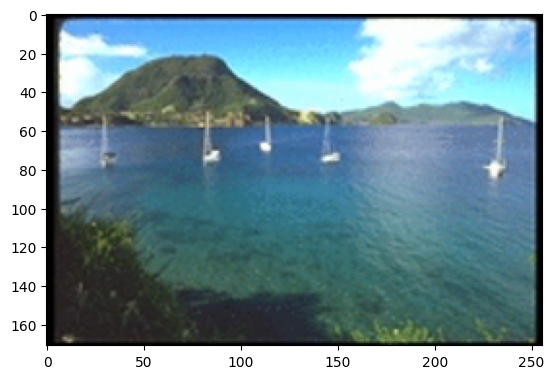

239.0625


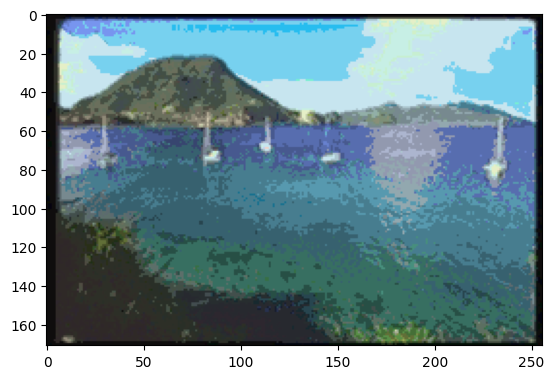

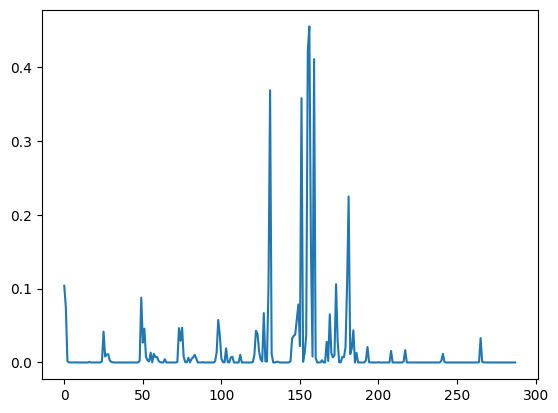

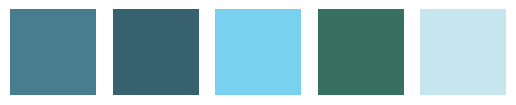

[(6, 1, 4), (6, 1, 3), (6, 1, 7), (5, 1, 3), (6, 0, 7)]


In [43]:

def processHSVHistogram(image_name, nH, nS, nV):
    PathImage = './Base/'  # to be completed
    nom = image_name # to be completed
    
    # quantization parameters
    nH = nH # to be completed
    nS = nS # to be completed
    nV = nV # to be completed
    
    filename= nom;
    I = np.array(Image.open(PathImage + filename))
    I = I / 255.  # I values range in [0,1]
    
    # conversion RGB->HSV
    J = rgb2hsv(I)
    
    # color palette computation
    palette, palette2 = setColors( nH, nS , nV );
    
    # Image quantization (your function)
    Iq, histo = quantizeImage(J, nH, nS, nV)
    # Visualisation of quantized image
    viewQuantizedImage(Iq , palette2)
    
    # flat a 3D histogram to 1D
    histo = histo.flat
    
    # Histogram normalization (your function)
    histo = normalize(histo)
    
    plt.figure()
    plt.plot(histo)
    plt.show()
    
    ## Determine 5 more frequent colors
    idx_most_prevalent = (-histo).argsort()[:5]
    hsv_most_prevalent = [np.unravel_index(idx,( nH, nS , nV )) for idx in idx_most_prevalent]
    
    display5mainColors(histo, palette)
    
    print(hsv_most_prevalent)

I = np.array(Image.open('./Base/' + 'Paysages67.png'))
I = I / 255.  # I values range in [0,1]
plt.figure();
plt.imshow(I);
plt.show()
processHSVHistogram('Paysages67.png', 12, 3, 8)


5) Change the values of ```nH```, ```nS```  and ```nV``` and analyze the results. You can try with other images in the base.

testing with nH=12, nS=3, nV=8
239.0625


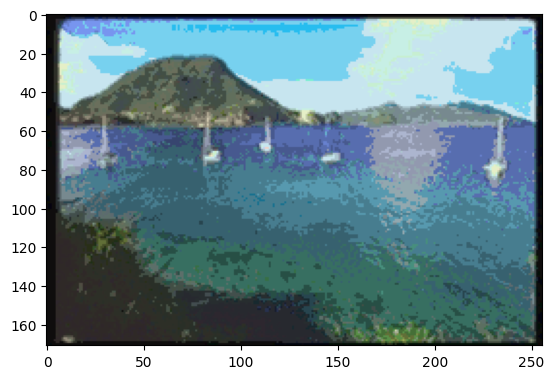

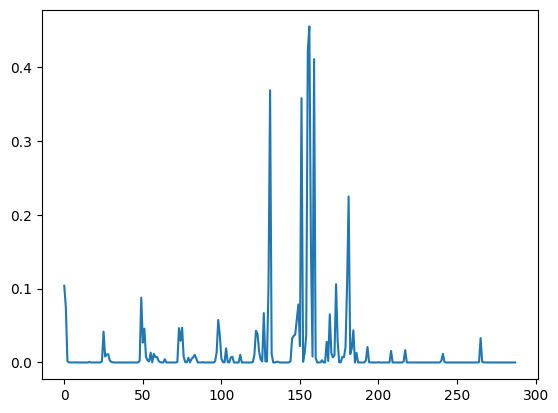

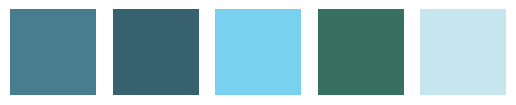

[(6, 1, 4), (6, 1, 3), (6, 1, 7), (5, 1, 3), (6, 0, 7)]
testing with nH=12, nS=3, nV=8
239.0625


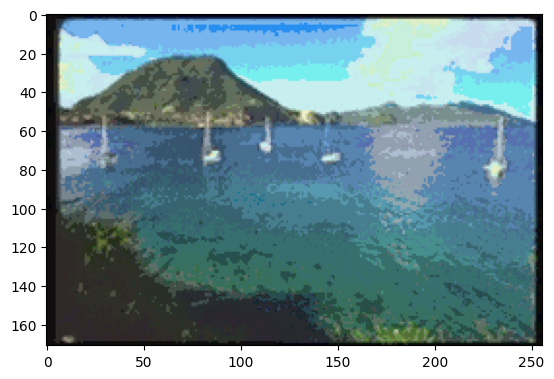

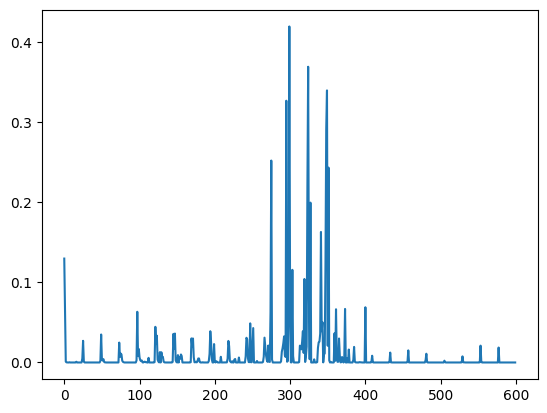

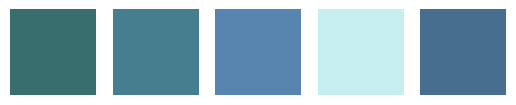

[(12, 1, 3), (13, 1, 4), (14, 1, 5), (12, 0, 7), (14, 1, 4)]
testing with nH=12, nS=3, nV=8
239.0625


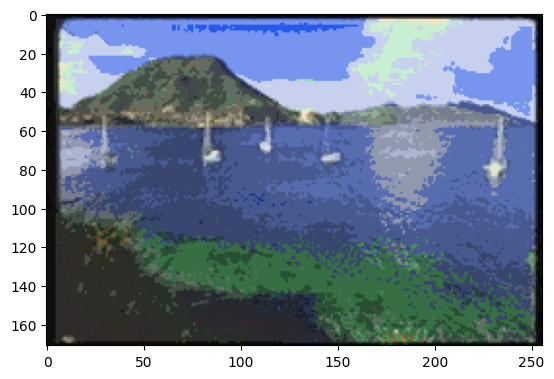

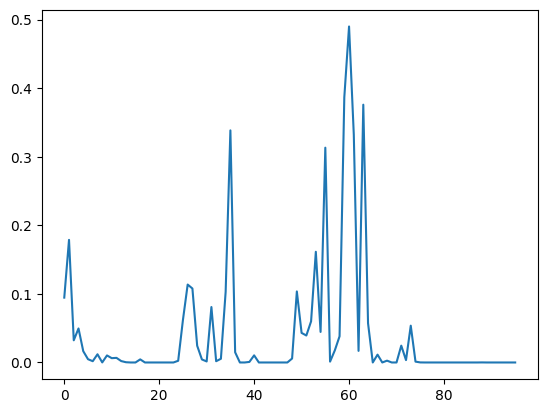

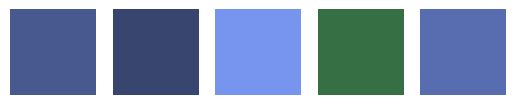

[(2, 1, 4), (2, 1, 3), (2, 1, 7), (1, 1, 3), (2, 1, 5)]
testing with nH=12, nS=3, nV=8
239.0625


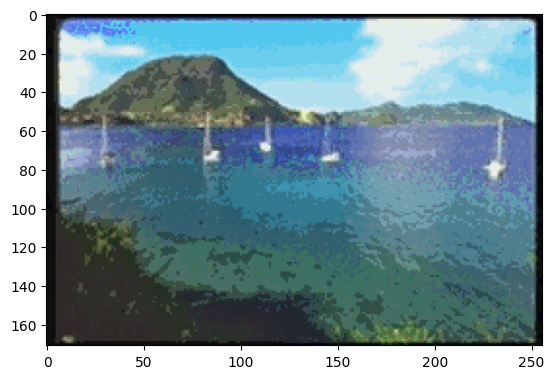

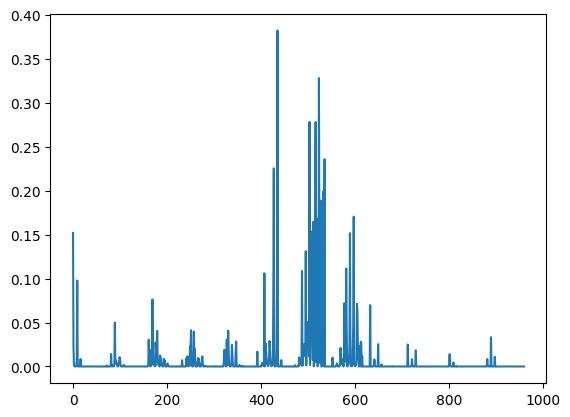

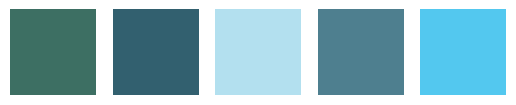

[(5, 4, 3), (6, 5, 3), (6, 4, 4), (6, 2, 7), (6, 6, 7)]
testing with nH=12, nS=3, nV=8
239.0625


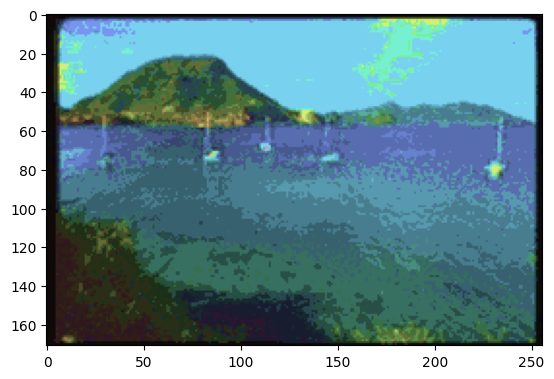

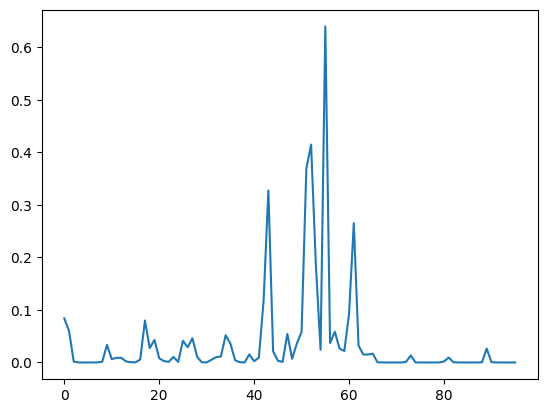

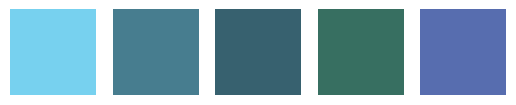

[(6, 0, 7), (6, 0, 4), (6, 0, 3), (5, 0, 3), (7, 0, 5)]
testing with nH=12, nS=3, nV=8
239.0625


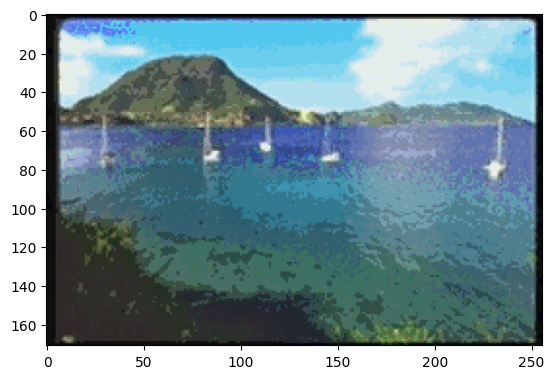

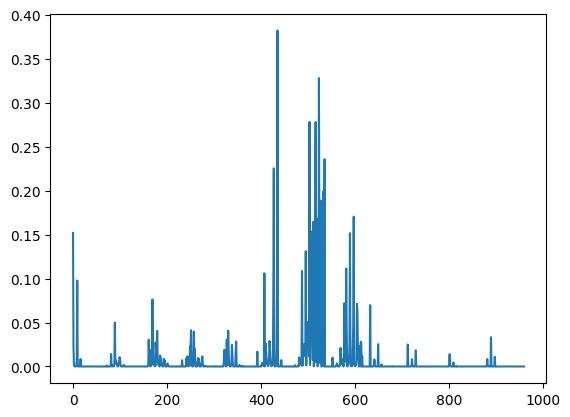

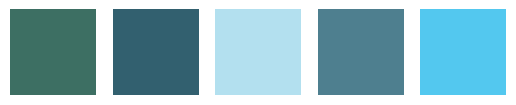

[(5, 4, 3), (6, 5, 3), (6, 4, 4), (6, 2, 7), (6, 6, 7)]
testing with nH=12, nS=3, nV=8
239.0625


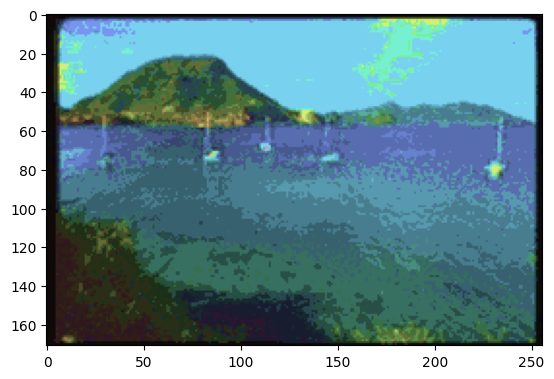

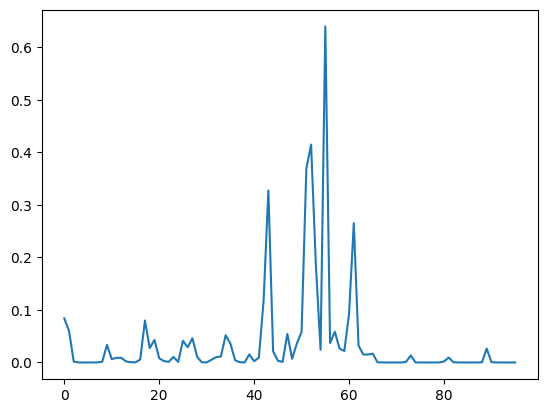

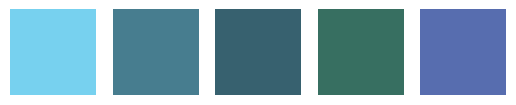

[(6, 0, 7), (6, 0, 4), (6, 0, 3), (5, 0, 3), (7, 0, 5)]


In [49]:
params = [
    {'nH': 12, 'nS': 3, 'nV': 8},
    
    {'nH': 25, 'nS': 3, 'nV': 8},
    {'nH': 4, 'nS': 3, 'nV': 8},
    
    {'nH': 12, 'nS': 10, 'nV': 8},
    {'nH': 12, 'nS': 1, 'nV': 8},

    {'nH': 12, 'nS': 10, 'nV': 8},
    {'nH': 12, 'nS': 1, 'nV': 8},
    
]
for param in params:
    print(f'testing with nH={nH}, nS={nS}, nV={nV}')
    processHSVHistogram('Paysages67.png', param['nH'], param['nS'], param['nV'])


6) What can you say about the results?

1. Effect of nH (Hue Bins):

    Determines how finely the Hue channel (color type) is divided. Higher values allow more distinct colors, while lower values merge colors.
    Observation:
        Higher nH (e.g., 16): More diverse colors are represented in the quantized image. Colors like red, blue, and green are distinguished more precisely.
        Lower nH (e.g., 6): Colors are generalized, and similar hues (e.g., red and orange) may appear as a single color.
    Conclusion: Larger nH values are useful for preserving subtle color variations, especially in colorful images, while smaller nH values are better for simplifying the palette.

2. Effect of nS (Saturation Bins):

    Determines how the Saturation channel (intensity or vividness of color) is quantized. Higher values better capture intensity variations.
    Observation:
        Higher nS (e.g., 5): Different levels of vividness (e.g., strong vs. muted colors) are preserved, resulting in a more detailed quantization.
        Lower nS (e.g., 2): Colors with varying intensities are grouped together, reducing the detail in color vividness.
    Conclusion: Higher nS values are essential for images with varying color intensities, while lower values reduce complexity.

3. Effect of nV (Value Bins):

    Determines how brightness levels (Value channel) are quantized. Higher values capture more brightness variations.
    Observation:
        Higher nV (e.g., 12): Shadows, highlights, and subtle brightness differences are preserved, adding depth to the quantization.
        Lower nV (e.g., 4): Brightness levels are simplified, and shadows or gradients may appear flat.
    Conclusion: Larger nV values are suitable for images with significant brightness variation, while smaller values simplify brightness representation.

## Exercise 2: Similarity between images: 

In this exercise, we will compute a measure of similarity between two images from the normalized histogram. This measure of similarity will be used in order to find images that are the most similar to a given image.

### Question 2.1:  Computation of the histograms for the whole base

Complete the following script to compute the histograms for every image in the base. As the computation can take a lot of time, we will do it only one time and store the result in ```ListHisto.mat```. The results will be stored as a ```N x M``` array ```listHisto``` with ```N = 1040``` and ```M = nH x nS x nV ```. We will also save the names of the images as ```listImage```

Set ```bcomputed = False``` for the first run to compute the database histograms and then set it to 1.


In [4]:
import os
from scipy.io.matlab import loadmat, savemat
try:
    from tqdm.notebook import tqdm
except ImportError:
    print("tqdm not installed, you can install it with the following command:")
    print("  pip3 install tqdm --user")
    print("and remove it with the following command:")
    print("  pip3 unistall tqdm")


#####

pathImage = './Base/'
pathDescriptors = './'

# Quantization HSV
nH = 12
nS = 3
nV = 8

bcomputed = True # Set to False to compute the histogramm database

if not bcomputed:
    listImage = sorted(os.listdir(pathImage))
    listHisto = []
    print('Histogram database computation ... it may take a while ...')
    for imageName in listImage:
        if os.path.isfile(pathImage+imageName) and imageName[-4:] == '.png':
            # print( imageName)
            # read image
            I = np.array(Image.open(pathImage+imageName)) / 255.

            # conversion RGB->HSV
            J = rgb2hsv(I);
            # Image quantization (your function tested in Exo 1)
            _,histo = quantizeImage(J, nH, nS, nV)
  
            # flat a 3D histogram in 1D
            histo = histo.flatten()
            
            # Normalize histogramme (your function tested in Exo 1)
            listHisto.append(normalize(histo))

    print(len(listHisto), "histograms computed")
    nomList = pathDescriptors+'ListHisto.mat'
    savemat(nomList, {'listHisto': np.array(listHisto),
                      'listImage': np.array(listImage)})
else:
    print("Histogram database computation already done.")

Histogram database computation already done.


### Question 2.2: Computation of the similarity between every image in the base.

   1. Write a function ```similarityMatrix()``` or a script that performs the similarity computation for every pair of images in the base from the histograms stored in ```listHisto``` and store the result in a ```1040 x 1040``` matrix ```S```. It is possible to make the operation much faster by using only one matrix operation.

In [5]:
import numpy as np
from scipy.io import loadmat, savemat

# Load histograms and image list
mat = loadmat(pathDescriptors + 'ListHisto.mat')
listHisto = mat['listHisto']
listImage = mat['listImage']

# Computes the similarity matrix for all pairs of histograms.
def similarityMatrix(histograms):
    """
    Parameters:
        histograms (numpy.ndarray): A 2D array of shape (N, M), where N is the 
                                    number of histograms and M is the number 
                                    of bins in each histogram.
    output:
        numpy.ndarray: A 2D array of shape (N, N) representing the similarity matrix.
    """    
    # Compute the similarity matrix using dot product (cosine similarity)
    similarity = np.dot(histograms, histograms.T)
    return similarity

# Compute the similarity matrix
print("Computing the similarity matrix...")
S = similarityMatrix(listHisto)
print("Similarity matrix computation completed")


Computing the similarity matrix...
Similarity matrix computation completed


2. Display the matrix `S`  as an image. What can we say about this it ?

- Diagonal Brightness: The diagonal elements are bright (high intensity), indicating maximum similarity between each histogram and itself (S[i,i]=1S[i,i]=1 for normalized histograms).
- Clusters of Brightness: Blocks of bright regions off the diagonal suggest groups of images with similar histograms (i.e., similar colors or distributions).
- Sparsity: Most off-diagonal elements are darker (low intensity), indicating weak similarity between most image pairs.

Clusters of Similar Images: The bright blocks represent clusters of images that share similar color distributions.
Variety in the Dataset: The sparsity in the off-diagonal values suggests diversity in the dataset, with most images having distinct color distributions.

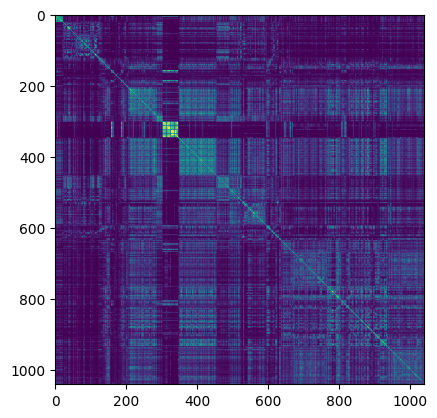

In [21]:
plt.imshow(S)

3. Assuming `S` is already computed and using function `display20bestMatches()`, test on the image `Liontigre1.png` (indexQuery=349). You should obtain something similar to Figure 5.

![figure5.png](./figs/Figure_5.png)
<center>Figure 5: 20 best matches of image 'Liontigre1.png'</center>

Inquiring image: Liontigre1.png (index 349)


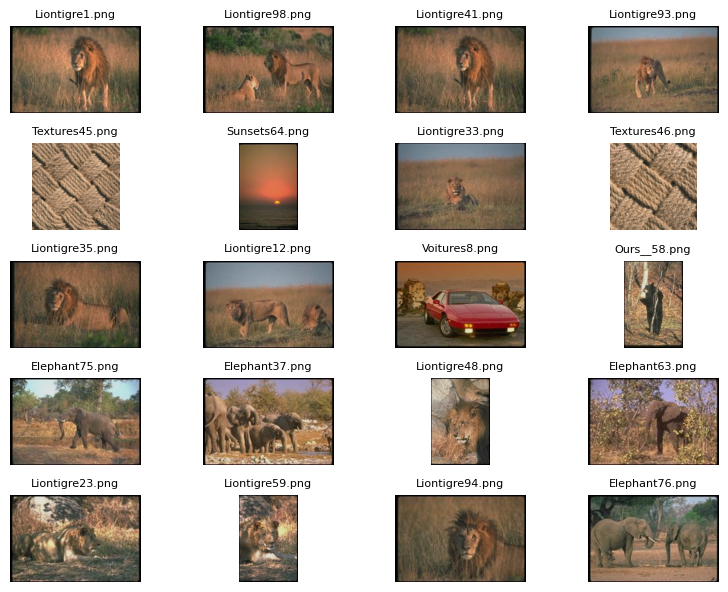

In [21]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Displays the 20 best matching images for a query image based on the similarity matrix.
def display20bestMatches(S, indexQuery, listImage, pathImage):
    """    
    Parameters:
        S (numpy.ndarray): Similarity matrix of size N x N.
        indexQuery (int): Index of the query image.
        listImage (numpy.ndarray): List of image names.
        pathImage (str): Path to the folder containing the images.
    """
    # Get the similarity scores for the query image
    similarities = S[indexQuery]
    
    # Sort indices by similarity scores in descending order
    sorted_indices = np.argsort(similarities)[::-1]
    
    # Select the top 20 matches (including the query image itself)
    best_matches = sorted_indices[:20]
    
    # Display the query image
    query_image = Image.open(os.path.join(pathImage, listImage[indexQuery].strip()))
    plt.figure(figsize=(8, 6))  # Adjusted figure size for 5x4 layout
    
    # Display the 20 best matches
    for i, match_idx in enumerate(best_matches, start=1):
        match_image = Image.open(os.path.join(pathImage, listImage[match_idx].strip()))
        plt.subplot(5, 4, i)
        plt.imshow(match_image)
        image_title = os.path.basename(listImage[match_idx].strip())  # Use the image name
        plt.title(image_title, fontsize=8)
        plt.axis("off")
    
    plt.tight_layout(pad=1.0)  # Adjust spacing between images
    plt.show()

# Example usage
indexQuery = 349
imageName = (pathImage + listImage[indexQuery]).strip()
print(f"Inquiring image: {os.path.basename(imageName)} (index {indexQuery})")
display20bestMatches(S, indexQuery, listImage, pathImage)


4. Assuming `S` is already computed, generate a random query (an integer in the range $[0, 1039]$), and display the 20 best matches.


Random query image: Paysages71.png (index 598)


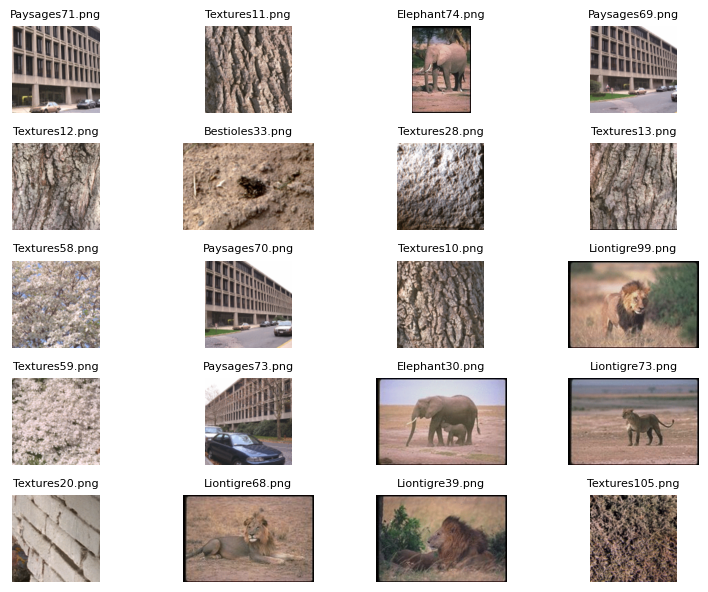

In [27]:
import random

# Generate a random query index
random_query = random.randint(0, 1039)

# Get the name of the query image
imageName = (pathImage + listImage[random_query].strip())
print(f"Random query image: {os.path.basename(imageName)} (index {random_query})")

# Display the 20 best matches
display20bestMatches(S, random_query, listImage, pathImage)


5. What can you say about the results? What are the limitations and the advantages of this method?

The method retrieves the 20 most similar images based on a similarity matrix, which ranks images based on feature similarity to the query. If the features are well-chosen, the top matches should be visually relevant. The query image is usually in the first position, followed by similar images.

Limitations:

    Feature Dependence: The method relies on feature extraction, and poor feature selection can lead to irrelevant matches.
    Scalability: Computing similarity matrices for large datasets is computationally expensive, requiring optimizations like dimensionality reduction or approximate nearest neighbor search.
    Lack of Context: It ranks images based solely on similarity scores, not considering semantic meaning, so visually similar but contextually different images may be retrieved.
    Query Image Inclusion: The query image is often included in results unless explicitly excluded.
    No Categorization: It doesn't group images by category, leading to mixed results if there are multiple classes in the dataset.

Advantages:

    Simplicity: Easy to understand and implement.
    Flexibility: Allows experimentation with different feature extraction methods.
    Applicability: Useful for image retrieval tasks, like finding similar images or in recommendation systems.
    Customizability: Can be tailored to prioritize specific types of similarity (color, texture, etc.).